In [1]:
import pyperclip
from PIL import ImageGrab,Image
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from math import ceil, floor, sin, pi

from bs4 import BeautifulSoup

import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh


In [2]:
# Carga archivo de coordenadas de referencias usadas para el mapeo
indice_puntos_mapeo = []
puntos_mapeo1=[]
archivo = open("mapeo_sl_facemesh.svg", "rt")
sopa = BeautifulSoup( archivo, features = 'xml')
archivo.close()
# se determina factores de escalamiento
final_width = int(sopa.svg['width'])
final_height = int(sopa.svg['height'])
final_viewBox = [float(x) for x in sopa.svg['viewBox'].split()]
escala_x = final_width / ( final_viewBox[2] - final_viewBox[0] )
escala_y = final_height / ( final_viewBox[3] - final_viewBox[1] )
for punto in sopa.svg.find('g', id= 'layer3').find_all('rect'):
    idx = punto['id'].split('_')
    if len(idx) > 1:
        indice_puntos_mapeo.append( int(idx[1]) )
        puntos_mapeo1.append({ 'x':float(punto['x']) * escala_x , 'y':float(punto['y']) * escala_y })
puntos_mapeo_df = pd.DataFrame(puntos_mapeo1, index = indice_puntos_mapeo)
puntos_mapeo_df = puntos_mapeo_df.sort_index()
puntos_mapeo_df

,x,y
0,511.745543,389.184043
1,512.245537,313.029415
2,511.995521,347.779458
5,511.917739,281.988075
6,511.899294,218.712320
...,...,...
457,541.917701,311.863075
464,583.773588,234.173313
465,566.686117,236.108768
466,673.063341,227.803736


In [3]:
areas = [
    #sobre las cejas
    #[109, 107, 9, 10], [10, 9, 336, 338], [67, 66, 107, 109], [338, 336, 296,297], [103, 105, 66, 67],
    #[297, 296, 334, 332], [54, 63, 105, 103], [332, 334, 293, 284], [162, 127, 143, 156], [162, 156, 63, 54],
    #[284, 293, 383, 389], [383, 372, 356, 389],
    # Orbitas
    [156, 143, 130, 247], [63, 156, 247, 29], [105, 63, 29, 28], [105, 28, 190, 66], [66, 190, 122, 107],
    [107, 122, 6, 9], [336, 9, 6, 351], [296, 336, 351, 414], [334, 296, 414, 258], [334, 258, 259, 293],
    [293, 259, 467, 383], [383, 467, 359, 372], [372, 359, 255, 340], [255, 254, 347, 340], [252, 349, 347, 254],
    [464, 465, 349, 252], [414, 351, 465, 464], [190, 244, 245, 122], [244, 22, 120, 245], [24, 118, 120, 22],
    [25, 111, 118, 24], [143, 111, 25, 130],
    #parpado izquierdo
    [190, 173, 133, 244], [28, 158, 173, 190], [28, 29, 160, 158], [29, 247, 246, 160], [247, 130, 33, 246],
    [130, 25, 7, 33], [7, 25, 24, 144], [153, 144, 24, 22], [133, 153, 22, 244],
    #parpado derecho
    [414, 464, 362, 398], [362, 464, 252, 380], [380, 252, 254, 373], [373, 254, 255, 249], [359, 263, 249, 255],
    [467, 466, 263, 359], [259, 387, 466, 467], [258, 385, 387, 259], [258, 414, 398, 385],
    # NAriz
    [122, 245, 131, 51], [6, 122, 51, 5], [6, 5, 281, 351], [351, 281, 360, 465], [131, 129, 237, 51], [5, 51, 237, 1],
    [5, 1, 457, 281], [360, 281, 457, 358], [237, 129, 98, 20], [237, 20, 94, 1], [457, 1, 94, 250], [457, 250, 327, 358],
    [20, 98, 97, 94], [250, 94, 326, 327], [20, 97, 2, 94], [250, 94, 2, 326],
    # alrededor boca
    [129, 205, 206, 98], [358, 327, 426, 425], [205, 212, 57, 206], [425, 426, 287, 432], [98, 206, 57, 39],
    [98, 39, 37, 97], [2, 97, 37, 0], [2, 0, 267, 326], [327, 326, 267, 269], [327, 269, 287, 426], [212, 204, 91, 57],
    [91, 204, 194, 181], [181, 194, 201, 84], [84, 201, 200, 17], [314, 17, 200, 421], [405, 314, 421, 418],
    [321, 405, 418, 424], 
    [287, 321, 424, 432],
    # Labios
    [185, 57, 91, 78], [39, 185, 78, 81], [37, 39, 81, 82], [37, 82, 13, 0], [267, 0, 13, 312], [267, 312, 311, 269],
    [269, 311, 308, 409], [409, 308, 321, 287], [308, 402, 405, 321], [317, 314, 405, 402], [317, 14, 17, 314],
    [87, 84, 17, 14], [87, 178, 181, 84], [78, 91, 181, 178],
    # Cachete izquierdo
    #[127, 234, 111, 143], [111, 234, 132, 147], [132, 136, 212, 147], [111, 147, 205, 118], [147, 136, 212, 205],
    [118, 205, 129, 120], [245, 120, 129, 131],
    # Cachete derecho
    #[356, 372, 340, 454], [340, 376, 361, 454], [361, 376, 432, 365], [340, 347, 425, 376], [425, 432, 365, 376],
    [347, 349, 358, 425], [465, 360, 358, 349],         
    # Menton
    #[136, 149, 204, 212],[365, 432, 424, 378], [204, 149, 176, 194], [424, 418, 400, 378],
    [194, 176, 148, 201],
    [201, 148, 152, 200],
    [200, 152, 377, 421],
    [418, 421, 377, 400],
]
lineas_alpha =[
    [156, 143],
    [143, 111],
    [111, 118],
    [118, 205],
    [205, 212],
    [212, 204],
    [204, 194],
    [194, 176],
    [176, 148],
    [148, 152],
    [152, 377],
    [377, 400],
    [400, 418],
    [418, 424],
    [424, 432],
    [432, 425],
    [425, 347],
    [347, 340],
    [340, 372],
    [372, 383],
]

In [4]:
# valida que las areas referencien todos los puntos recolectados
def validar_puntos(etiqueta, lineas):
    todos_puntos = list(set([ a for b in lineas for a in b]))
    puntos_faltantes = [a for a in todos_puntos if a not in puntos_mapeo_df.index]
    if len(puntos_faltantes) == 0:
        print('{0}: Diagramación es consistente'.format(etiqueta))
    else:
        print('{1}: validar los siguientes puntos: {0}'.format(str(puntos_faltantes), etiqueta))
        areas_problema = [ area for area in areas for punto in puntos_faltantes if punto in area ]
        print("\n".join([str(area) for area in areas_problema] ))

validar_puntos('Areas',areas)
validar_puntos('Lineas Alfa',lineas_alpha)


Areas: Diagramación es consistente
Lineas Alfa: Diagramación es consistente


In [5]:
def imagen_portapapeles():
    
    try:
        # Intentar abrir el contenido como una imagen
        image = ImageGrab.grabclipboard()
        
        # Convertir la imagen a formato OpenCV (cv2)
        image_cv2 = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        
        return image_cv2
    
    except :
        # El contenido no es una imagen
        return None
    
def mostrar_imagen(imagen):
    # Convertir la imagen de BGR a RGB
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGBA)

    # Mostrar la imagen utilizando matplotlib
    plt.imshow(imagen_rgb)
    plt.axis('off')
    plt.show()
    
def mostrar_imagen_gray(imagen):

    # Mostrar la imagen utilizando matplotlib
    plt.imshow(imagen)
    plt.axis('off')
    plt.show()
    


# Aquí comienza la acción
Capturar con el portapapeles una imagen con un rostro antes de ejecutar el siguiente paso

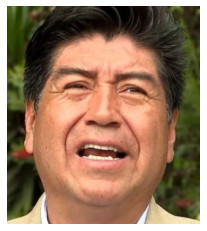

In [86]:
#Ejecutar teniendo imagen en el portapapeles

imagen = imagen_portapapeles()
if imagen is None:
    print('No hay imagen en el portapapeles')
else:
    mostrar_imagen(imagen)

In [87]:
# Extraelas marcas
results = None
with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
    results = face_mesh.process(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
print(results)

<class 'mediapipe.python.solution_base.SolutionOutputs'>


Marcando marcas #0


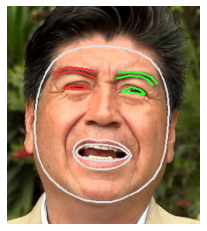

In [88]:
# Aplica marcas sobre copia 
annotated_image = np.copy(imagen)
face_landmarks_list = results.multi_face_landmarks
for idx in range(len(face_landmarks_list)):
    print('Marcando marcas #{0}'.format(idx))
    face_landmarks = face_landmarks_list[idx]
    
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    
mostrar_imagen(annotated_image)

In [89]:
# Transforma las landmarks en un Dataframe
idx_marcas = 0
face_landmarks = face_landmarks_list[idx_marcas]
ancho = imagen.shape[1]
alto = imagen.shape[0]
puntos_landmarks = [ (idx,x.x,x.y) for idx,x in enumerate(face_landmarks.landmark) ]
landmarks_df = pd.DataFrame( [{'x':q[1] * ancho, 'y':q[2] * alto } for q in puntos_landmarks] , index = [q[0] for q in puntos_landmarks] )
landmarks_df

,x,y
0,138.663882,205.145108
1,147.045901,175.559917
2,146.027718,186.830225
3,141.799287,147.634166
4,147.741367,165.891301
...,...,...
473,194.765084,130.199696
474,202.019209,131.103133
475,195.760689,123.710775
476,187.625726,129.245824


In [90]:
# Realiza cruce de dataframes para tener mapeo de coordenadas
cruce_df = puntos_mapeo_df.join(landmarks_df, how='left', lsuffix='_destino', rsuffix='_origen')
cruce_df

,x_destino,y_destino,x_origen,y_origen
0,511.745543,389.184043,138.663882,205.145108
1,512.245537,313.029415,147.045901,175.559917
2,511.995521,347.779458,146.027718,186.830225
5,511.917739,281.988075,148.471059,154.971237
6,511.899294,218.712320,149.982772,130.805041
...,...,...,...,...
457,541.917701,311.863075,160.327789,176.038202
464,583.773588,234.173313,166.901332,132.480688
465,566.686117,236.108768,162.865914,133.334872
466,673.063341,227.803736,208.498997,132.399935


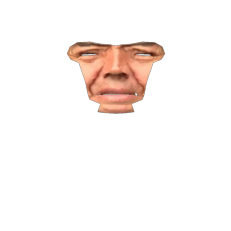

In [91]:
#cruce_df.loc[466,'x_destino']
malla_inicial = np.zeros( imagen.shape, dtype=np.uint8 )
malla_final = np.zeros( (final_height, final_width, 4), dtype=np.uint8 )
imagen_alpha = cv2.cvtColor(imagen, cv2.COLOR_BGR2BGRA)
for indice in range(0, len(areas)):
    area = areas[indice]
    
    imagen_mascara = np.zeros( imagen_alpha.shape, dtype=np.uint8 )
    mascara_recorte = np.zeros( (final_height, final_width) , dtype=np.uint8 )
    
    pol1 = [ (cruce_df.loc[ p ,'x_origen'], cruce_df.loc[ p ,'y_origen'])
            for p in area
    ]
    pol2 = [ (cruce_df.loc[ p ,'x_destino'], cruce_df.loc[ p ,'y_destino'])
            for p in area
    ]
        
    pol1_int = np.array(pol1, dtype=np.int32)
    pol2_int = np.array(pol2, dtype=np.int32)
    pol1_float = np.array(pol1, dtype=np.float32)
    pol2_float = np.array(pol2, dtype=np.float32)
    
    cv2.fillPoly( imagen_mascara, pts=[pol1_int], color=(255,255,255,255) )
    cv2.polylines( imagen_mascara, [pol1_int], True, (255,255,255,255), 3 )
    cv2.fillPoly( mascara_recorte, pts=[pol2_int], color=(255,) )
    cv2.polylines( malla_inicial, [pol1_int], True, (255,255,255,255), 1 )

    mascara_recorte_inv = cv2.bitwise_not(mascara_recorte)
    
    area_enmascarada = cv2.bitwise_and(imagen_mascara, imagen_alpha)
    #if indice == 0:
    #    mostrar_imagen(mascara_recorte)
    
    if len(area) < 4:
        continue
    
    try:
        matriz_transformacion = cv2.getPerspectiveTransform(pol1_float, pol2_float)
        recorte = cv2.warpPerspective(area_enmascarada, matriz_transformacion, (final_width , final_height) )
        #malla_final = cv2.bitwise_or(malla_final, recorte)
        malla_final = cv2.add( cv2.bitwise_and(malla_final,malla_final,mask=mascara_recorte_inv) , 
                              cv2.bitwise_and(recorte,recorte,mask=mascara_recorte) )
    except Exception as ex:
        print("Error \n{1}\n{2}\n{0}\n".format(str(ex), recorte.dtype, mascara_recorte.dtype ))
        #print("Error \n{1}\n{2}\n{0}\n".format(str(ex), str(pol1), str(pol2) ))

# mostrar_imagen(malla_inicial)
mostrar_imagen(malla_final)

malla_2 = np.copy(malla_final)

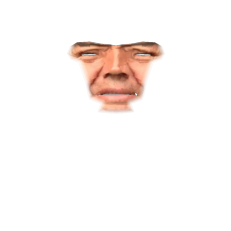

In [92]:
# Traza lineas alpha en zonas de difuminado
numero_lineas_alfa = 10
malla_b, malla_g, malla_r, malla_a = cv2.split(malla_final)
malla_a1 = np.copy(malla_a)
for ancho in range(numero_lineas_alfa -1, -1,-1):
    color = int((ancho + 1) * 256 / (numero_lineas_alfa + 1))
    for linea in lineas_alpha:
        cv2.line(malla_a1, ( int(cruce_df.loc[ linea[0], 'x_destino' ]), int(cruce_df.loc[ linea[0], 'y_destino' ] ) ), ( int(cruce_df.loc[ linea[1], 'x_destino' ]) , int(cruce_df.loc[ linea[1], 'y_destino' ]) ) , (color,) , (ancho + 1) * 5 )

malla_a1 = cv2.bitwise_and(malla_a, malla_a1, mask = malla_a)

malla_final = cv2.merge([malla_b, malla_g, malla_r, malla_a1])

malla_2 = np.copy(malla_final)

mostrar_imagen(malla_final)


3 173 225


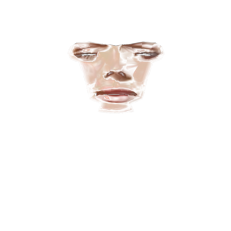

In [333]:
# modifica la capa alfa en funcion de las tonalidades
malla_b, malla_g, malla_r, malla_a = cv2.split(malla_final)
malla_gray = cv2.cvtColor(malla_final, cv2.COLOR_BGRA2GRAY)
tonos = np.array( list(set([ x for x in np.reshape(malla_gray, (final_width * final_height,) ) if x != 0 ])), dtype = np.uint8)
#mediana = np.median(tonos)
mediana = malla_gray[260, 543]
#mediana = np.average(tonos)
maximo = np.max(tonos)
minimo = np.min(tonos)
factor = 256 / (maximo - minimo)
print('{0} {1} {2}'.format(minimo, mediana, maximo))
malla_a1 = np.copy(malla_a)

for fila in range(0,malla_a1.shape[0]):
    for columna in range(0,malla_a1.shape[1]):
        if malla_a[fila,columna] == 0:
            continue
        elif malla_gray[fila, columna] >= mediana:
            malla_a1[fila,columna] = 255 * sin( (malla_gray[fila, columna] - mediana ) * pi / (maximo - mediana) )
        else:
            malla_a1[fila,columna] = 255 * sin( (mediana - malla_gray[fila, columna]) * pi / (mediana - minimo) )
            
malla_a1 = cv2.bitwise_and(malla_a, malla_a1)

malla_2 = cv2.merge([malla_b, malla_g, malla_r, malla_a1])
        
mostrar_imagen(malla_2)

In [93]:
# Graba la imagen obtenida
nombre_archivo = input("Nombre de archivo .png: ")
cv2.imwrite("{0}_face.png".format(nombre_archivo), malla_2)

Nombre de archivo .png: yunda


True